In [59]:
import pandas as pd
import numpy as np
import json
import seaborn as sns
import os
import cv2
from matplotlib import pyplot as plt

In [60]:
data_json = '../dataset/train.json'
data_json

'../dataset/train.json'

In [61]:
with open(data_json, 'r') as outfile:
    data = (json.load(outfile))

df_image = pd.DataFrame(data['images']) #이미지 데이터
df_annotation = pd.DataFrame(data['annotations']) #bbox 
df_categories = pd.DataFrame(data['categories'])#categories

In [62]:
print('Shape of df_image: ', df_image.shape)
print('Shape of df_annotation: ', df_annotation.shape)
print('Shape of df_categories: ', df_categories.shape)

Shape of df_image:  (4883, 8)
Shape of df_annotation:  (23144, 6)
Shape of df_categories:  (10, 3)


## 데이터 통합

    image, annotation, category 통합

        1. df_image의 id column을 image_id로 변경
        2. df_image와 df_annotation을 image_id를 통해 merege
        3. df_categories의 id를 category_id로 변경
        4. 그리고 merge

In [63]:
#df_image column 명 변경
df_image = df_image.rename(columns={'id':'image_id'})
df_image.columns

Index(['width', 'height', 'file_name', 'license', 'flickr_url', 'coco_url',
       'date_captured', 'image_id'],
      dtype='object')

In [64]:
df = df_image.merge(df_annotation, how='left', on='image_id')

In [65]:
df.shape

(23144, 13)

In [66]:
#df_categories column명 변경
df_categories = df_categories.rename(columns={'id':'category_id'})
df_categories.columns

Index(['category_id', 'name', 'supercategory'], dtype='object')

In [67]:
df = df.merge(df_categories, how='left', on='category_id')

## EDA 시작

    각 카테고리 개수

In [68]:
df_name = df['name'].value_counts()

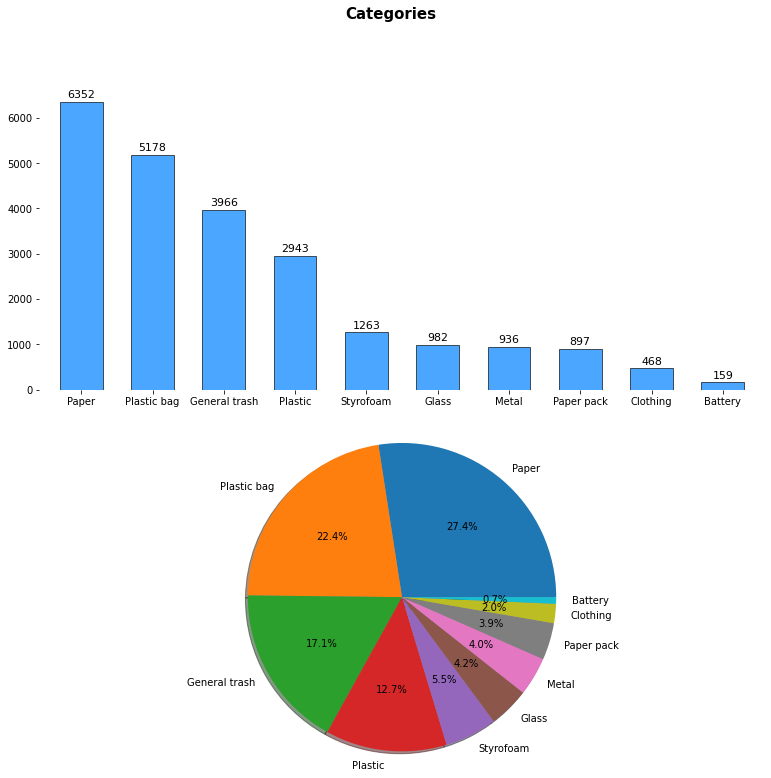

In [69]:
fig, axes= plt.subplots(2, 1, figsize=(13, 12))
##Bar Plot
fig.suptitle('Categories', fontweight='bold', fontsize=15)
axes[0].bar(df_name.index, df_name, width=0.6,color='dodgerblue', linewidth=0.8, edgecolor='black', alpha=0.8)
axes[0].margins(0.03)
axes[0].set(frame_on=False)
for idx, val in df_name.iteritems():
    axes[0].text(x=idx, y=val+50, s=val,
            va='bottom', ha='center',
            fontsize=11)
    
##Pie chart
axes[1].pie(df_name, labels=df_name.index, autopct='%1.1f%%', radius = 1.3, shadow=True)
plt.show()

## Annotation이 가장 많이 되어있는 image

In [79]:
df['annotated_file_name'] = 'annotated/' +df['file_name'].str.slice(start=6,)

In [80]:
df_image

width  height       file_name  license flickr_url coco_url  \
0      1024    1024  train/0000.jpg        0       None     None   
1      1024    1024  train/0001.jpg        0       None     None   
2      1024    1024  train/0002.jpg        0       None     None   
3      1024    1024  train/0003.jpg        0       None     None   
4      1024    1024  train/0004.jpg        0       None     None   
...     ...     ...             ...      ...        ...      ...   
4878   1024    1024  train/4878.jpg        0       None     None   
4879   1024    1024  train/4879.jpg        0       None     None   
4880   1024    1024  train/4880.jpg        0       None     None   
4881   1024    1024  train/4881.jpg        0       None     None   
4882   1024    1024  train/4882.jpg        0       None     None   

            date_captured  image_id annotated_file_name  
0     2020-12-26 14:44:23         0  annotated/0000.jpg  
1     2021-01-10 16:30:39         1  annotated/0001.jpg  
2     2020-12-27 17:55:52         2  annotated/0002.jpg  
3     2021-03-31 12:10:36         3  annotated/0003.jpg  
4     2021-01-01 18:52:38         4  annotated/0004.jpg  
...                   ...       ...                 ...  
4878  2021-01-04 14:36:54      4878  annotated/4878.jpg  
4879  2021-04-27 13:46:18      4879  annotated/4879.jpg  
4880  2020-12-24 11:25:46      4880  annotated/4880.jpg  
4881  2021-01-05 11:01:18      4881  annotated/4881.jpg  
4882  2020-12-23 16:20:30      4882  annotated/4882.jpg  

[4883 rows x 9 columns]

In [93]:
series = df['image_id'].value_counts()
df_temp = series.to_frame()
df_temp.rename(columns={'image_id':'count'}, inplace=True)
df_temp.reset_index(inplace=True)
df_temp=df_temp.rename(columns={'index':'id'})

In [94]:
df_merge = df_image.rename(columns={'image_id':'id'})
df_merge = df_merge[['id', 'annotated_file_name']]

In [95]:
df_count = df_temp.merge(df_merge, how='left', on='id')
df_count.head(10)

id  count annotated_file_name
0  4197     71  annotated/4197.jpg
1   946     55  annotated/0946.jpg
2  4047     52  annotated/4047.jpg
3   394     48  annotated/0394.jpg
4  2981     46  annotated/2981.jpg
5  2416     46  annotated/2416.jpg
6  1955     46  annotated/1955.jpg
7  1678     44  annotated/1678.jpg
8  4492     42  annotated/4492.jpg
9  1797     42  annotated/1797.jpg

## Annotation개수 상위 10개 출력

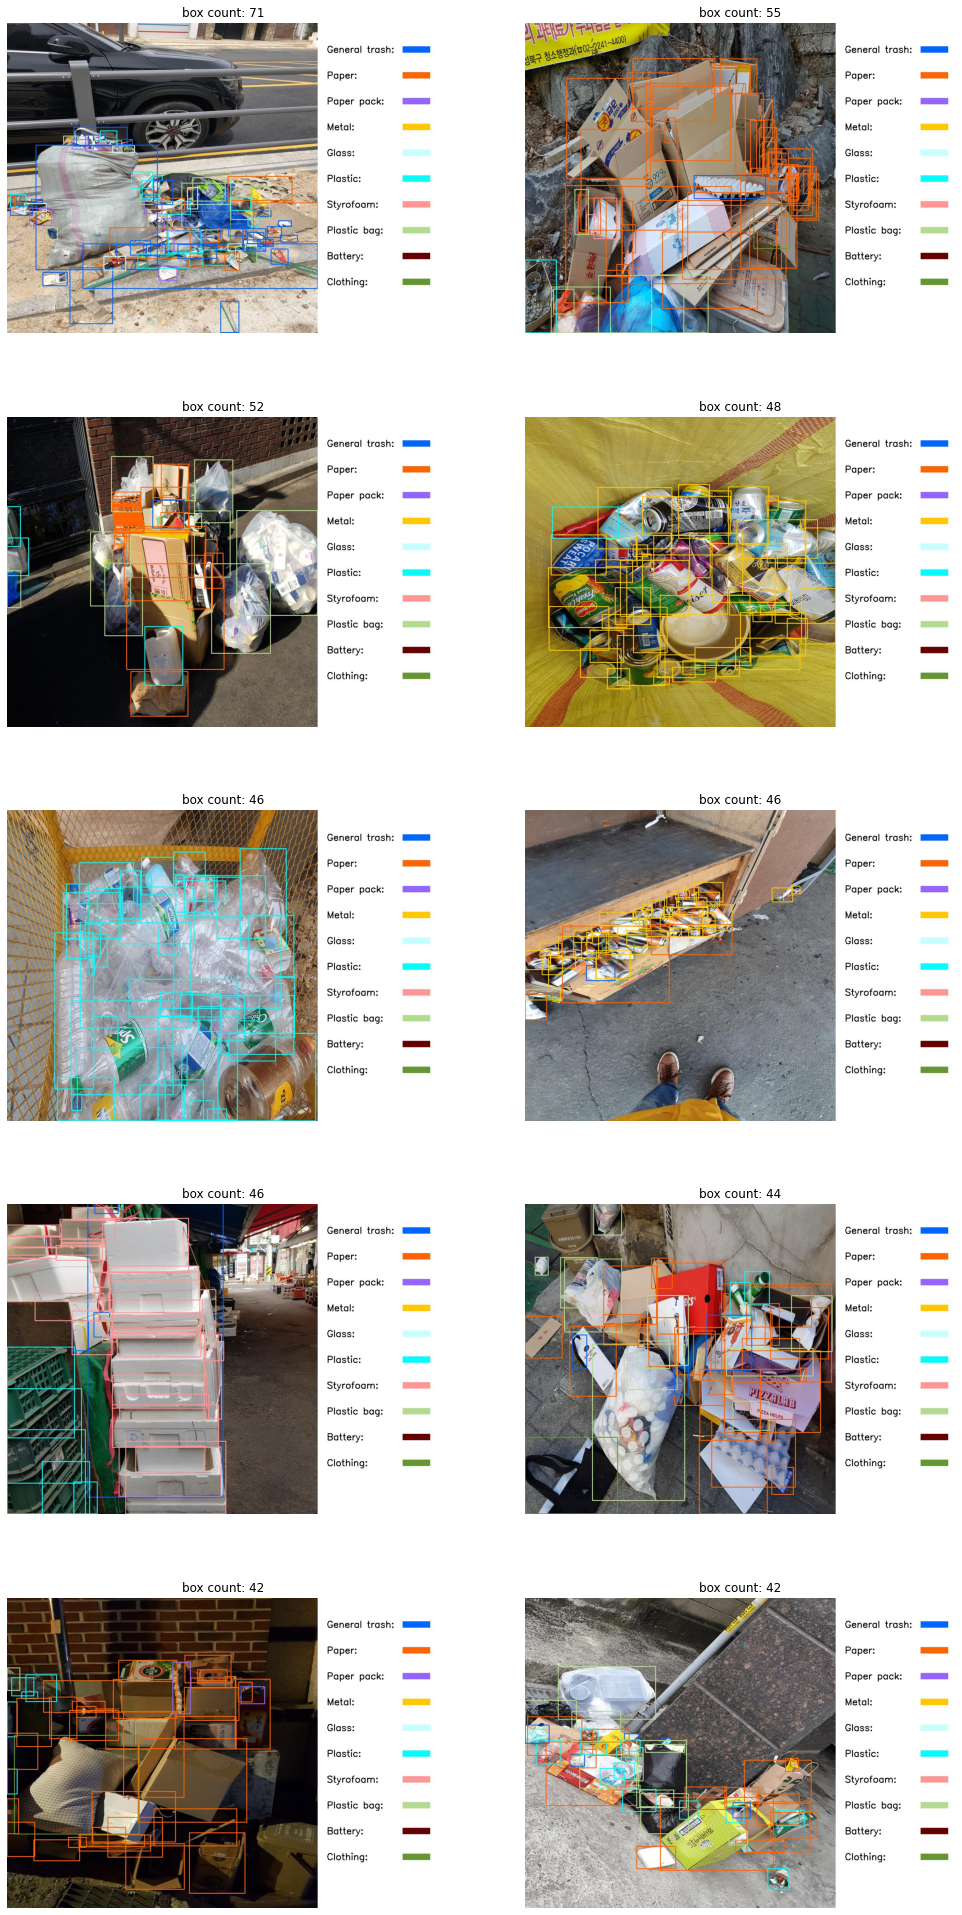

In [96]:
base_dir = '/opt/ml/detection/dataset/'
fig, axes = plt.subplots(5, 2, figsize=(17,35))
idx = 0

for i in range(5):
    for j in range(2):
        title = df_count['count'].iloc[idx]
        axes[i][j].set_title(f'box count: {title}')
        axes[i][j].axis("off")
        img = cv2.imread(base_dir + df_count['annotated_file_name'].iloc[idx])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        axes[i][j].imshow(img)
        idx+=1


## Annotation 하위 10개 출력

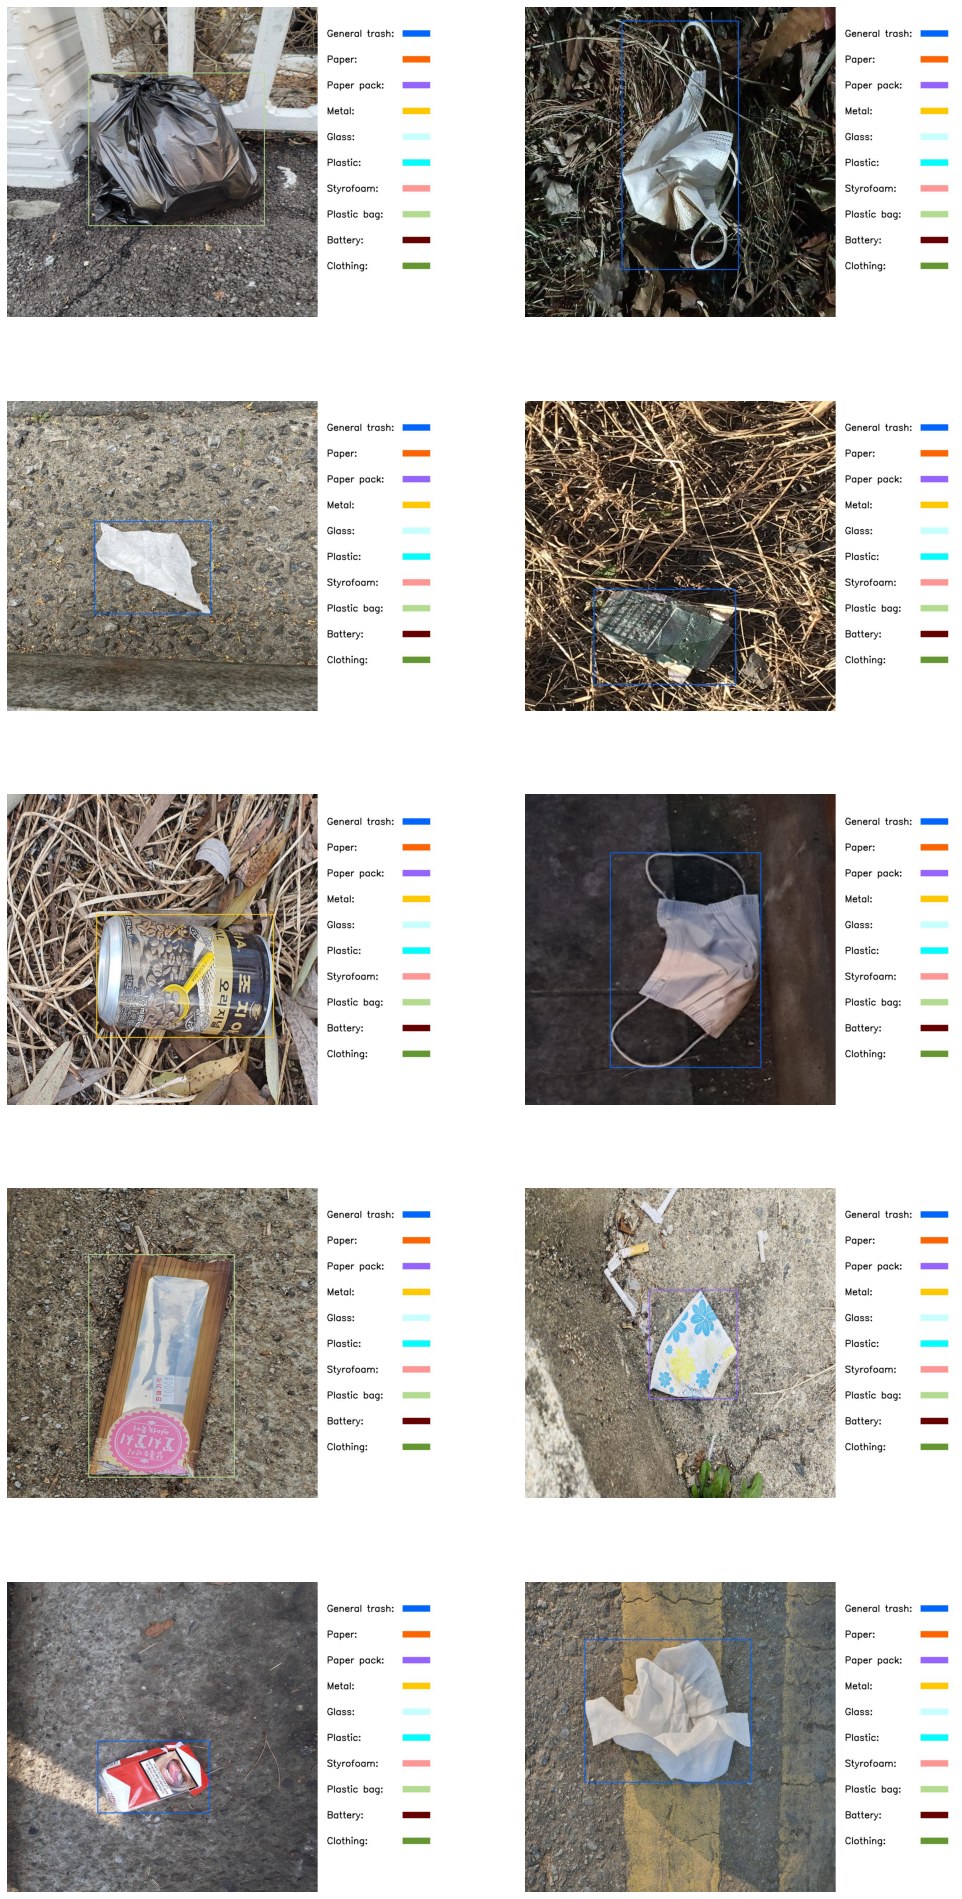

In [97]:
base_dir = '/opt/ml/detection/dataset/'
fig, axes = plt.subplots(5, 2, figsize=(17,35))
idx = len(df_count)-10

for i in range(5):
    for j in range(2):
        
        axes[i][j].axis("off") #x축, y축 지우기
        img = cv2.imread(base_dir + df_count['annotated_file_name'].iloc[idx])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        axes[i][j].imshow(img) #이미지 출력
        idx+=1

## 이미지당 annotation 개수를 히토그램을 통해 시각화

In [98]:
df_ccount = df_count['count'].value_counts().to_frame()
df_ccount = df_ccount.reset_index()
df_ccount.columns=['count', 'amount']

a_list = []
for count in df_ccount['count']:
    
    if count <= 2:
        a_list.append('count <= 2')
    elif count > 1 and count <= 10:
        a_list.append('2 < count <= 10')
    elif count > 10 and count < 30:
        a_list.append('10 <= count < 30')
    else:
        a_list.append('count >= 30')

df_ccount['range'] = a_list
df_gcount = df_ccount.groupby(['range']).sum().reset_index()
df_gcount = df_gcount.sort_values(by=['amount'], ascending=False)
df_gcount
    

range  count  amount
2        count <= 2      3    2763
1   2 < count <= 10     52    1502
0  10 <= count < 30    380     561
3       count >= 30    748      57

<AxesSubplot:title={'center':'Range/Amount'}, xlabel='range', ylabel='amount'>

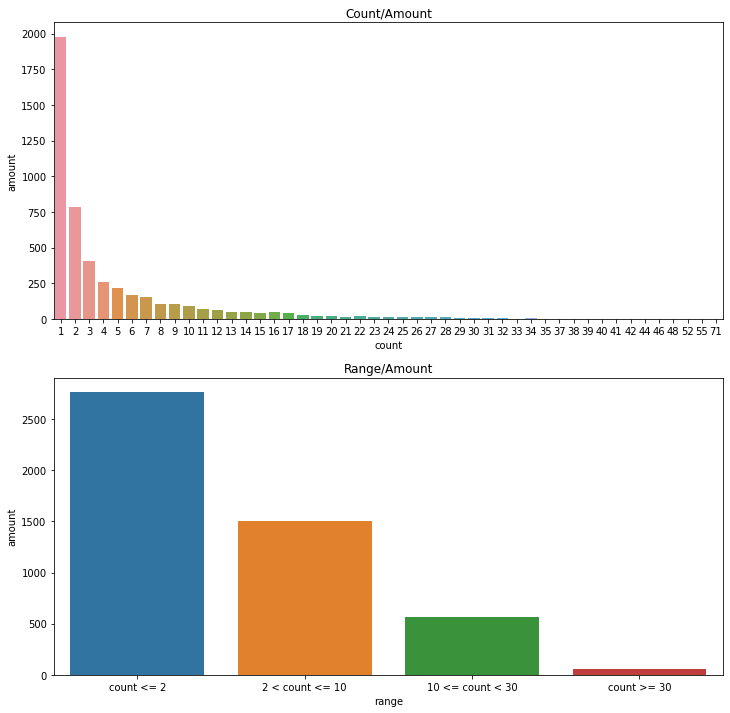

In [99]:
fig, ax = plt.subplots(2, 1, figsize=(12,12))
ax[0].set_title('Count/Amount')
ax[1].set_title('Range/Amount')
sns.barplot(x='count', y='amount',data=df_ccount, ax=ax[0])
sns.barplot(x='range', y='amount',data=df_gcount, ax=ax[1])

## Validated data 분석

In [139]:
valid_json_tested = '/opt/ml/detection/mmdetection/work_dirs/result.bbox.json'

with open(valid_json_tested, 'r') as outfile:
    data_tested = (json.load(outfile))

print(len(data_tested), len(df))

22971 23144


In [140]:
valid_json = '/opt/ml/detection/dataset/val_fold1.json'

with open(valid_json, 'r') as outfile:
    data_train = (json.load(outfile))

vlen = len(data_train['images'])
vlen

989

In [141]:
train_json = '/opt/ml/detection/dataset/train_fold1.json'

with open(train_json, 'r') as outfile:
    data_val = (json.load(outfile))

tlen = len(data_val['images'])
tlen

3894

In [133]:
vlen + tlen

4883

In [135]:
df_val_image = pd.DataFrame(data_val['images']) #이미지 데이터
df_val_image

width  height       file_name  license flickr_url coco_url  \
0      1024    1024  train/0000.jpg        0       None     None   
1      1024    1024  train/0003.jpg        0       None     None   
2      1024    1024  train/0004.jpg        0       None     None   
3      1024    1024  train/0005.jpg        0       None     None   
4      1024    1024  train/0006.jpg        0       None     None   
...     ...     ...             ...      ...        ...      ...   
3889   1024    1024  train/4877.jpg        0       None     None   
3890   1024    1024  train/4878.jpg        0       None     None   
3891   1024    1024  train/4879.jpg        0       None     None   
3892   1024    1024  train/4881.jpg        0       None     None   
3893   1024    1024  train/4882.jpg        0       None     None   

            date_captured    id  
0     2020-12-26 14:44:23     0  
1     2021-03-31 12:10:36     3  
2     2021-01-01 18:52:38     4  
3     2021-01-02 16:48:22     5  
4     2020-12-27 17:09:20     6  
...                   ...   ...  
3889  2021-01-02 12:38:32  4877  
3890  2021-01-04 14:36:54  4878  
3891  2021-04-27 13:46:18  4879  
3892  2021-01-05 11:01:18  4881  
3893  2020-12-23 16:20:30  4882  

[3894 rows x 8 columns]